<a href="https://colab.research.google.com/github/RehanShabbir16/Modern_computer_vision_with_pytorch/blob/main/Intel_image_classification_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100% 345M/346M [00:16<00:00, 23.3MB/s]
100% 346M/346M [00:16<00:00, 21.4MB/s]


In [ ]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
train_data='/content/seg_train/seg_train'
test_data='/content/seg_test/seg_train'
val_data='/content/seg_pred/seg_pred'


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import cv2
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from torchvision import transforms

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from random import shuffle,seed

In [ ]:
classes=os.listdir(train_data)
classes

['mountain', 'buildings', 'glacier', 'street', 'forest', 'sea']

In [ ]:
class IntelDataset(Dataset):
    def __init__(self, folder):
        self.classes = classes
        self.fpaths = []
        self.targets = []

        for i, cls in enumerate(self.classes):
            path = glob(os.path.join(folder, cls, '*'))
            self.fpaths.extend(path)
            self.targets.extend([i] * len(path))

        # Combine paths and targets, shuffle them for randomness
        combine = list(zip(self.fpaths, self.targets))
        seed(42)
        shuffle(combine)
        self.fpaths, self.targets = zip(*combine)

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, idx):
        f = self.fpaths[idx]
        target = self.targets[idx]
        img = cv2.imread(f)

        # Resize the image
        img = cv2.resize(img, (64, 64))

        # Normalize the image and convert to tensor
        img_tensor = torch.tensor(img / 255.0).permute(2, 0, 1).float()

        return img_tensor, torch.tensor([target]).long()

In [ ]:
def conv_layer(ni,no,kernel_size,stride=1):
  return nn.Sequential(
      nn.Conv2d(ni,no,kernel_size,stride),
      nn.BatchNorm2d(no),
      nn.ReLU()
  )

In [ ]:
def get_model():
  model=nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,128,3),
      conv_layer(128,512,3),
      conv_layer(512,512,3),
      nn.Flatten(),
      nn.Linear(512*(64-8)*(64-8),6)
  ).to(device)
  loss_fn=nn.CrossEntropyLoss()
  opt=Adam(model.parameters(),lr=1e-3)
  return model,loss_fn,opt

In [ ]:
def get_data():
  train_dl=IntelDataset(train_data)
  train_data1=DataLoader(train_dl,batch_size=16,shuffle=True)
  return train_data1

In [ ]:
def train_batch(x,y,model,loss_fn,opt):
  model.train()
  opt.zero_grad()
  pred=model(x)
  loss=loss_fn(pred,y)
  loss.backward()
  opt.step()
  return loss.item()

In [ ]:
train_data=get_data()


In [ ]:
model,loss_fn,opt=get_model()

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary
# summary(model,(3,150,150))

In [ ]:
from helper_functions import accuracy_fn

In [ ]:
losses, accuracies = [], []
for epoch in range(5):
    print(f"Epoch: {epoch}")

    # Initialize lists to store batch losses and accuracies
    epoch_losses, epoch_accuracies = [], []

    # Variables to accumulate total correct predictions and total samples
    total_correct = 0
    total_samples = 0

    # Training loop
    model.train()
    for ix, batch in enumerate(iter(train_data)):
        x, y = batch
        y = y.squeeze(1)  # Squeeze the target to make it 1D
        batch_loss = train_batch(x.to(device), y.to(device), model, loss_fn,opt)
        epoch_losses.append(batch_loss)

        # Calculate predictions and accuracy
        predictions = model(x.to(device))
        predicted_labels = predictions.argmax(dim=1)

        # Update the total correct predictions and total samples
        total_correct += (predicted_labels == y.to(device)).sum().item()
        total_samples += y.size(0)

    # Average training loss for the epoch
    train_epoch_loss = np.mean(epoch_losses)

    # Training accuracy
    train_epoch_accuracy = (total_correct / total_samples) * 100

    # Append results to lists
    losses.append(train_epoch_loss)
    accuracies.append(train_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f} | Train Accuracy: {train_epoch_accuracy:.2f}%")

Epoch: 0
Train Loss: 34.3216 | Train Accuracy: 59.27%
Epoch: 1
Train Loss: 0.9699 | Train Accuracy: 73.49%
Epoch: 2
Train Loss: 0.6531 | Train Accuracy: 81.62%
Epoch: 3
Train Loss: 0.5539 | Train Accuracy: 86.35%
Epoch: 4
Train Loss: 0.4587 | Train Accuracy: 90.44%


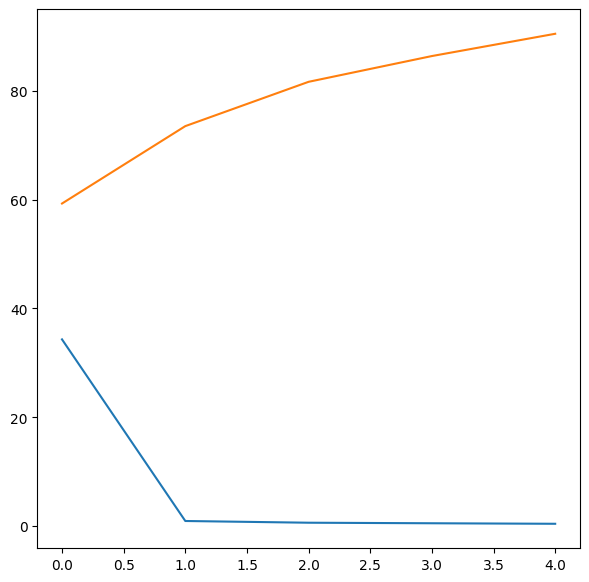

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(losses)
plt.plot(accuracies)

In [ ]:
torch.save(model.to('cpu').state_dict(), 'mymodel.pth')

In [ ]:
import torch
import torchvision.transforms as transforms
import cv2

model_path = '/content/mymodel.pth'
model1 = get_model()[0]
model1.load_state_dict(torch.load(model_path))
model1.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def predict_image(image_path):
  """Predicts the class of an image using the loaded model.

  Args:
    image_path: Path to the image file.

  Returns:
    Predicted class label.
  """

  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img_tensor = transform(img).unsqueeze(0).to(device)

  with torch.no_grad():
    output = model1(img_tensor)
    predicted_class = output.argmax(dim=1).item()

  return predicted_class




Predicted class: 5


In [ ]:
def get_test_data():
  test_dl=IntelDataset(test_data)
  test_data1=DataLoader(test_dl,batch_size=64,shuffle=True)
  return test_data1

In [ ]:
image_path1 = '/content/seg_pred/seg_pred/1003.jpg'
image_path2 = '/content/seg_pred/seg_pred/10079.jpg'
predicted_label1 = predict_image(image_path1)
predicted_label2 = predict_image(image_path2)
print("Predicted class:", predicted_label1)
print("Predicted class:", predicted_label2)

Predicted class: 5
Predicted class: 3


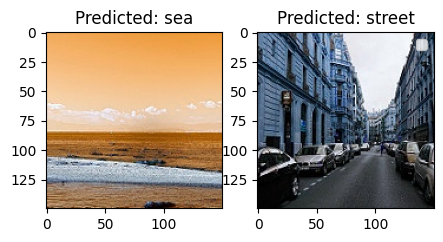

In [ ]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(image_path1))
plt.title(f"Predicted: {classes[predicted_label1]}")
plt.subplot(1,2,2)
plt.imshow(cv2.imread(image_path2))
plt.title(f"Predicted: {classes[predicted_label2]}")
plt.legend()